In [1]:
import sys
sys.path.insert(0, '/home/emmanuel/code/kernellib')

import numba
import numpy as np
from sklearn.utils import check_random_state
from kernellib.dependence import get_sample_data, HSIC
from kernellib.kernels import estimate_length_scale, rbf_kernel
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

plt.style.use('fivethirtyeight')

my_colors = [
    '#000000',
    '#ff0000', 
    
]

cmap=LinearSegmentedColormap.from_list('mycmap', my_colors)

%matplotlib inline
%load_ext autoreload
%autoreload 2

### Generate Sample Data

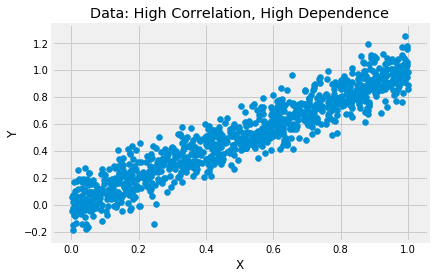

In [2]:
X, Y = get_sample_data(dataset='hh', num_points=1000, seed=1234, noise=0.1)

n_samples, d_dimensions = X.shape

fig, ax = plt.subplots()

ax.scatter(X, Y)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Data: High Correlation, High Dependence')
plt.show()

## HSIC Algorithm

### Step I: Compute Kernel

#### RBF Kernel

In [3]:
# Estimate Length_scale Parameters
sub_sample   = 1000
method       = 'median'
seed         = 1234

sigma_x = estimate_length_scale(
    X, 
    sub_sample=sub_sample,
    method=method,
    random_state=seed
)

sigma_y = estimate_length_scale(
    Y, 
    sub_sample=sub_sample,
    method=method,
    random_state=seed
)

print(f"\u03BB_x = {sigma_x:.4f}")
print(f"\u03BB_y = {sigma_x:.4f}")

λ_x = 0.2119
λ_y = 0.2119


In [4]:
# Calculate Kernel
K_x = rbf_kernel(X, length_scale=sigma_x)
K_y = rbf_kernel(Y, length_scale=sigma_y)

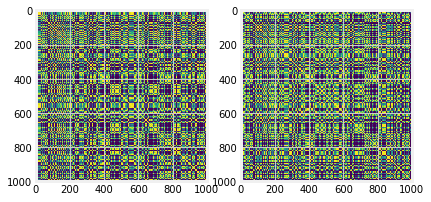

In [5]:
fig, ax = plt.subplots(nrows=1, ncols=2)

p0 = ax[0].imshow(K_x, )
p1 = ax[1].imshow(K_y, )

plt.show()

#### Linear Kernel

In [112]:
K_x = X @ X.T 
K_y = Y @ Y.T 

### Step II: Center Kernels

Kernel Centerer:
$$\text{H}=I- \left( \frac{1}{N}\right)\mathbb{1}$$

In [6]:
# Kernel Centerer
H = np.eye(n_samples) - (1 / n_samples) * np.ones(n_samples)

# Center the Kernels (X, Y)
K_xc = K_x @ H
K_yc = K_y @ H

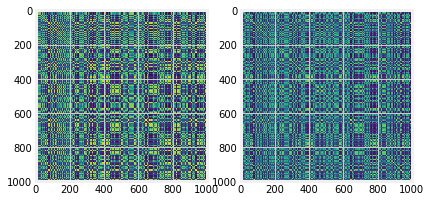

In [7]:
fig, ax = plt.subplots(nrows=1, ncols=2)

p0 = ax[0].imshow(K_xc, )
p1 = ax[1].imshow(K_yc, )

plt.show()

### Step III: Calculate HSIC Value

$$HSIC(\mathcal{F}, \mathcal{G}, \mathbb{P}_{xy})=\text{factor} * \text{Tr}(HK_xHK_y)$$

where:
* factor $=\frac{1}{(N - 1)^2}$

In [8]:
factor = 1 / (n_samples - 1)**2

hsic_value = factor * np.trace(K_xc @ K_yc)

print(hsic_value)

0.09844412262712675


#### Calculate HSIC Speedup

In [9]:
hsic_value = factor * np.einsum('ji,ij->', K_xc, K_yc)
print(hsic_value)

0.0984441226271268


In [10]:
%timeit np.trace(K_xc @ K_yc)
%timeit np.einsum('ji,ij->', K_xc, K_yc)

4.15 ms ± 822 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
1.16 ms ± 463 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)


### Derivative HSIC

In [26]:
def hsic_rbf_derivative(X, Y, H, Kx, Ky, sigma_x, sigma_y):
    
    # ===============
    # X
    # ===============

    # initialize params
    derX = np.zeros(X.shape)
    HKyH = H @ Ky @ H

    # Loop Through Dimensions & Samples
    for idx in range(d_dimensions):
        for isample in range(n_samples):
            de = ((X[isample, idx] - X[:, idx]) * Kx[:, isample])
            derX[isample, idx] = np.einsum('ij, ij->', HKyH[isample, :][:, None], de[:, None])

    derX *= factor * (-1 / sigma_x**2)
    # ===============
    # Y
    # ===============
    derY = np.zeros(Y.shape)
    HKxH = H @ Kx @ H
    # Loop Through Dimensions & Samples
    for idx in range(d_dimensions):
        for isample in range(n_samples):
            de = ((Y[isample, idx] - Y[:, idx]) * Ky[:, isample])
            derY[isample, idx] = np.einsum('ij, ij->', HKxH[isample, :][:, None], de[:, None])

    derY *= factor * (-1 / sigma_y**2)
    
    return derX, derY

In [27]:
derX, derY = hsic_rbf_derivative(
    X, Y, H, K_x, K_y, sigma_x, sigma_y
)

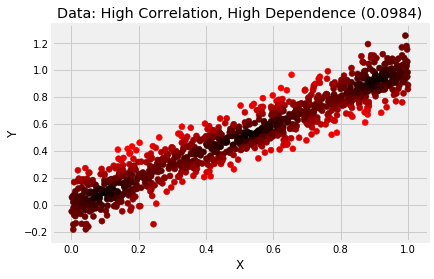

In [28]:
sens = np.sqrt(derX**2 + derY**2)


fig, ax = plt.subplots()

ax.scatter(X, Y, c=sens, cmap=cmap)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title(f'Data: High Correlation, High Dependence ({hsic_value:.4f})')
plt.show()

## HSIC Function (Kernellib)

In [29]:
# HSIC Method Parameters
kernel       = 'rbf'
sub_sample   = 1000
X_method     = 'median'
Y_method     = 'median'
seed         = 1234

# Initiate HSIC Model
hsic_model = HSIC(
    kernel=kernel,
    X_stat=X_method,
    Y_stat=Y_method,
    sub_sample=sub_sample,
    random_state=seed
)

# Fit HSIC Model to Data
hsic_model.fit(X, Y);

# Display Results
print(f"HSIC value: {hsic_model.hsic_value:.5f}")

HSIC value: 0.09844


In [30]:
print(f"\u03BB_x: {hsic_model.sigma_x:.4f}")
print(f"\u03BB_y: {hsic_model.sigma_y:.4f}")

λ_x: 0.2119
λ_y: 0.2207


In [31]:
%%time
derX_, derY_ = hsic_model.derivative()

CPU times: user 710 ms, sys: 2.31 s, total: 3.02 s
Wall time: 112 ms


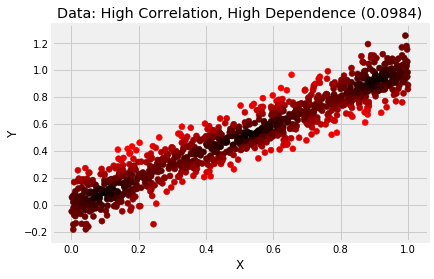

In [32]:
sens_f = np.sqrt(derX**2 + derY**2)


fig, ax = plt.subplots()

ax.scatter(X, Y, c=sens, cmap=cmap)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title(f'Data: High Correlation, High Dependence ({hsic_value:.4f})')
plt.show()